In [1]:
%load_ext autoreload
%autoreload 2

import os
import socket

cwd = os.getcwd()
hostname = socket.gethostname()

print(f"Host: {hostname}")
print(f"You are here: {cwd}")

from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import
print("Training results should now be reproducible.")

Host: deeplearning-vm
You are here: /home/sebelino7_gmail_com/pycharm_depl
Training results should now be reproducible.


# Train model

Invalidate cache entry: successful
Running trial 1/1 for unfreeze_last_l_blocks=3
[Trainer] Unfroze last 3 blocks


Update step:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [1/2], Loss: 2.1643, Train Acc: 59.61%, Val Acc: 91.01%
Epoch [2/2], Loss: 0.4834, Train Acc: 89.75%, Val Acc: 92.51%
Total elapsed: 27.13s, average per update step: 0.11s
[Trainer] Saved checkpoint to runs/checkpoints/2fa0309f9d8602f5bdfd489ff071e758.pth
Invalidate cache entry: successful
Running trial 1/1 for unfreeze_last_l_blocks=5
[Trainer] Unfroze last 5 blocks


Update step:   0%|          | 0/186 [00:00<?, ?it/s]

Epoch [1/2], Loss: 2.1380, Train Acc: 61.17%, Val Acc: 90.19%
Epoch [2/2], Loss: 0.4734, Train Acc: 89.92%, Val Acc: 86.51%
Total elapsed: 34.95s, average per update step: 0.16s
[Trainer] Saved checkpoint to runs/checkpoints/5a22d836926e2a261142bc2508b308d3.pth


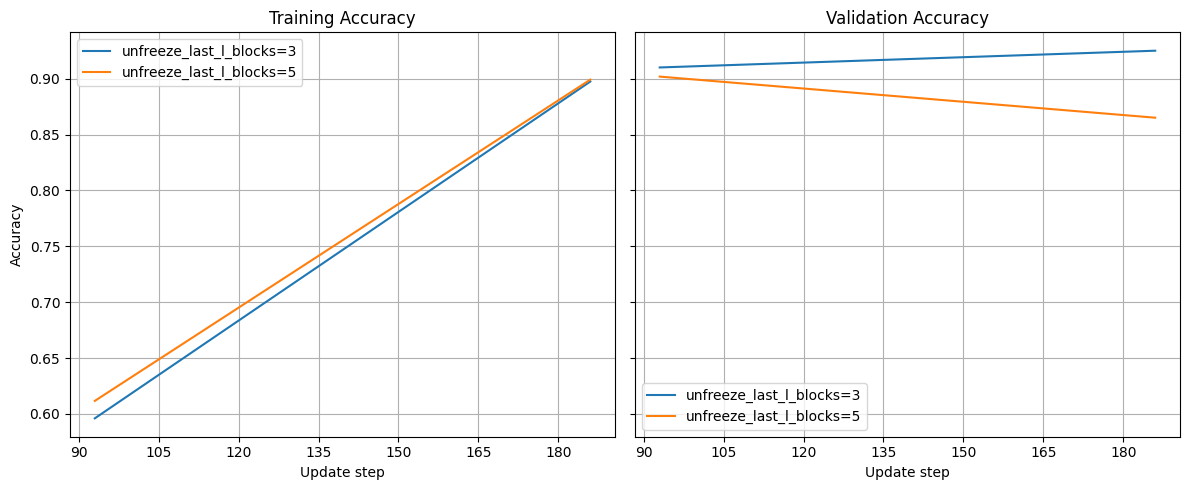

In [5]:
%reload_ext autoreload
%autoreload 2

from typing import Literal
import augmentation
from augmentation import AugmentationParams
from training import TrainParams, NagParams
from datasets import DatasetParams

dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    #class_fractions=(0.2,)*37,
    class_fractions=(1.0,) * 37,
    validation_set_fraction=0.2,  # 20 % of trainval set
)

architecture: Literal["resnet18", "resnet34", "resnet50"] = "resnet50"
baseline_params = TrainParams(
    seed=determinism.seed,
    architecture=architecture,
    n_epochs=2,
    optimizer=NagParams(
        learning_rate=0.0055905797197103695,
        weight_decay=9.123321505007701e-06,
        momentum=0.791610254744395,
    ),
    freeze_layers=True,
    #unfreezing_epochs=(2, 4),
    unfreezing_epochs=None,
    unfreeze_last_l_blocks=3,
    augmentation=AugmentationParams(
        enabled=False,
        transform=augmentation.to_transform(architecture, ["resize", "flip"])
    ),
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=None,
)

from evaluation import override_param_sets, evaluate_runs_ci
from run import run_multiple

overrides = [
    dict(unfreeze_last_l_blocks=3),
    dict(unfreeze_last_l_blocks=5),
]
param_sets = override_param_sets(baseline_params, overrides)
results = run_multiple(dataset_params, param_sets, determinism, invalidate=True, trials=1)
evaluate_runs_ci(results)

# Test model

In [ ]:

from run import try_loading_trainer
from evaluation import evaluate_test_accuracy
from torch.utils.data import DataLoader
from datasets import load_dataset
from training import Trainer
from util import suppress_weights_only_warning

suppress_weights_only_warning()

eval_params = baseline_params.copy()
trainer = try_loading_trainer(dataset_params, eval_params, determinism)

test_dataset = load_dataset("test", Trainer.make_base_transform(eval_params))
test_loader = DataLoader(
    test_dataset,
    batch_size=dataset_params.batch_size,
    shuffle=False,
    num_workers=3,
    persistent_workers=False,
    pin_memory=True,
    worker_init_fn=Determinism.data_loader_worker_init_fn(dataset_params.shuffler_seed),
)
print(f"Test size: {len(test_loader.dataset)}")

final_test_acc = evaluate_test_accuracy(trainer, test_loader)

print(f"Final Test Accuracy: {final_test_acc:.2f}%")

Trying to load trainer from disk...
Trainer not found. Retraining...


Update step:   0%|          | 0/1860 [00:00<?, ?it/s]

Epoch [1/20], Loss: 2.9546, Train Acc: 53.36%, Val Acc: 87.74%
Epoch [2/20], Loss: 1.2809, Train Acc: 80.48%, Val Acc: 90.74%
Epoch [3/20], Loss: 0.5749, Train Acc: 85.95%, Val Acc: 93.73%
Epoch [4/20], Loss: 0.3994, Train Acc: 89.41%, Val Acc: 94.28%
Epoch [5/20], Loss: 0.3049, Train Acc: 91.85%, Val Acc: 93.60%
Epoch [6/20], Loss: 0.2336, Train Acc: 94.09%, Val Acc: 94.96%
Epoch [7/20], Loss: 0.2138, Train Acc: 94.26%, Val Acc: 93.32%
Epoch [8/20], Loss: 0.1581, Train Acc: 95.76%, Val Acc: 93.46%
Epoch [9/20], Loss: 0.1492, Train Acc: 96.10%, Val Acc: 94.69%
Epoch [10/20], Loss: 0.1427, Train Acc: 96.84%, Val Acc: 94.14%
Epoch [11/20], Loss: 0.1140, Train Acc: 97.15%, Val Acc: 94.55%
Epoch [12/20], Loss: 0.0980, Train Acc: 97.56%, Val Acc: 94.14%
